# Time since infection
In this notebook, I'll consider time since infection and pdensity as a potential summary statistic by which we can score antigenic loci.
My plan is:
1. I'll plot the correlation of time since infection and immunity.
2. Compare correlation between pdensity and time since infection for various measures of pdensity, including all, initial, max, & total area of parasites.
3. Figure out how to turn the strongest of these relationships into a statistical test.
4. Run powercalcs for them.

In [1]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pandas as pd
import json
import powercalc as pc

## 1. Correlation between time since infection & immunity.

In [4]:
y=3
a = [10,10,10,10,10,10]
w = [0,1/5,1/5,1/5,1/5, 1/5]
eir = 40

In [221]:
fever,breaks = tent.load_data()
fever_arr = tent.get_fever_arr(eir,fever,breaks)
pmatrix, smatrix, imatrix, malaria,infectmatrix = tent.simulate_person(y,a,w,fever_arr)
visits = pc.get_visits(malaria,28,y)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/code/pfTent.py:164: RuntimeWarning: divide by zero encountered in reciprocal
  new_param = param/(c/np.tan(np.pi/2*x)**b+1)


In [222]:
def get_times_since(loci, allele, pmatrix, visits=[],infectmatrix=[]):
    '''
    Returns start times for all infections after the first infection.
    Returns the time since exposure for all infections after the first infection.
    If visits provided, start & end correspond to measured timepoints.
    If infectmatrix is provided, start & end correspond to true times.
    '''
    if len(visits):
        values = pmatrix[loci,allele,visits]
        positiveVisits = values.nonzero()[0]
        if len(positiveVisits):
            shifted = np.roll(positiveVisits,1)
            test = positiveVisits-shifted
            new = np.where(test>1)[0]
            starts = [visits[day] for day in positiveVisits[new]]
            if len(starts):
                lastPos = [visits[day] for day in positiveVisits[new-1]]
                times = [start - last for start,last in zip(starts,lastPos)]
        
    elif len(infectmatrix):
        bites = np.where(infectmatrix[loci+1,:] == allele)[0]
        all_starts = np.unique(infectmatrix[0,bites])
        if len(all_starts)>1:
            starts = all_starts[1:]
            lastPos = [pmatrix[loci,allele,:start].nonzero()[0][-1] for start in starts]
        else:
            starts=[]
    else:
        print("Must provide visits or infectmatrix & smatrix. If visits, will return measured time range of exposures. If infectmatrix & smatrix, will return true time range of exposures.")
    
    if len(starts):
        times = [start - last for start,last in zip(starts,lastPos)]
    else:
        times = []
    return starts, times

Let's check and see how well my code works!

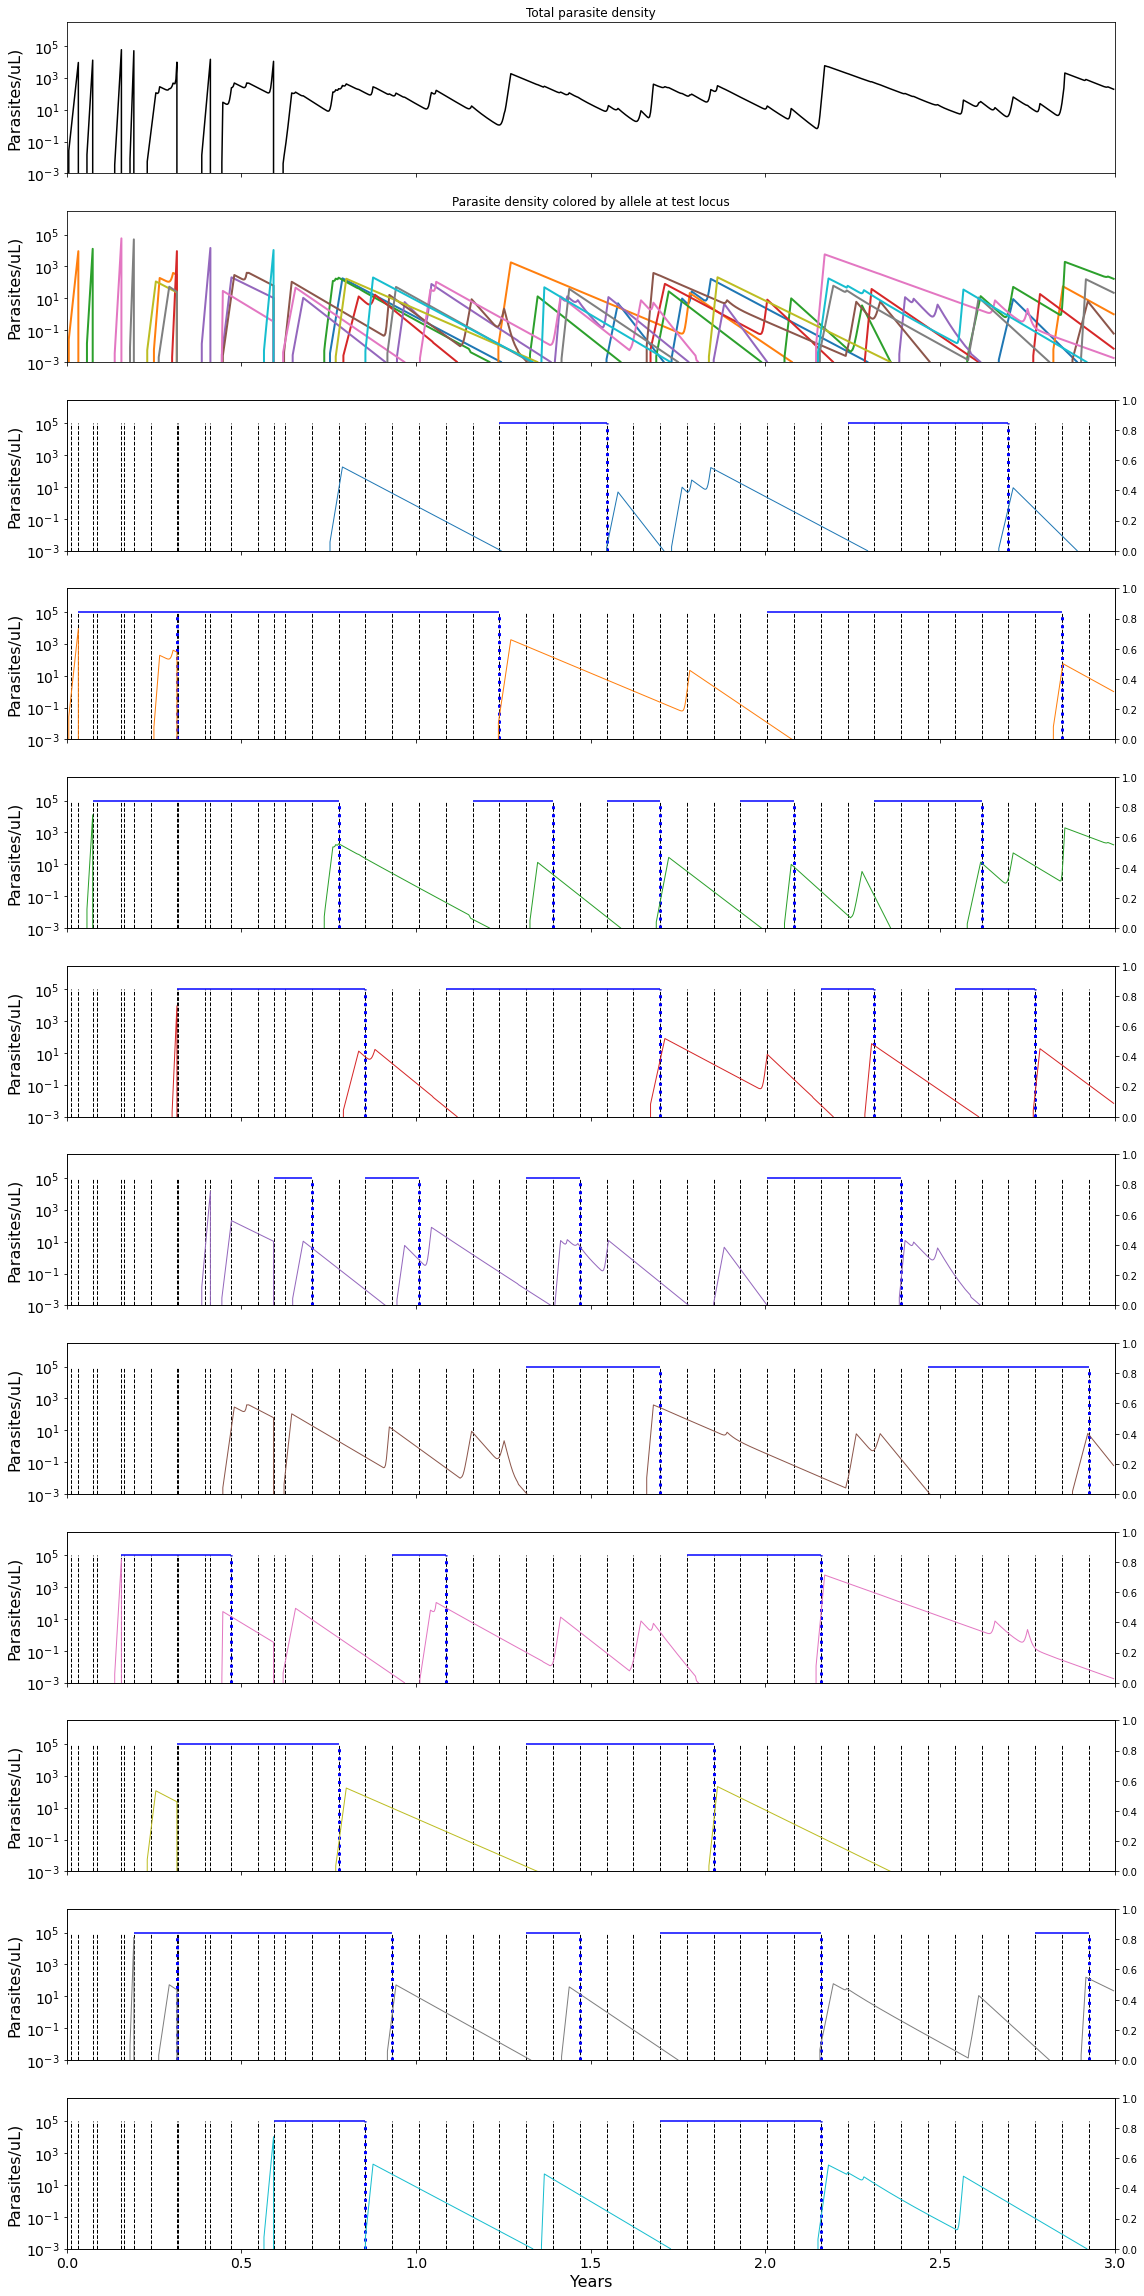

In [249]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(10):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[0].set_xlim(0,3)
#fig.suptitle('person ' + str(i),fontsize=18)
ax[11].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL)',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL)',fontsize=16)
for row in range(2,12):
    ax1 = ax[row].twinx()
    starts, times = get_times_since(5,row-2,pmatrix,visits=visits)
    starts = np.asarray(starts)
    mins = starts-np.asarray(times)
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL)',fontsize=16)
    other = [strain for strain in range(0,10) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=1,color=colors[row-2])
    #ax1.plot(np.arange(y*365)/365,imatrix[-1,row-2,:],linewidth=2,color=colors[row-2],linestyle="dotted")
    ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)
    ax[row].vlines(x=starts/365,ymin=0.001,ymax=100000,color="blue",linewidth=3,linestyle="dotted")
    for end,start in zip(mins,starts):
        ax[row].hlines(y=100000,xmin=end/365,xmax=start/365, color="blue")

It's working! Now, let's see how well it correlates with immunity.

In [299]:
n_people = 100
all_parasites, all_immunity, all_strains, all_malaria, all_infections = tent.simulate_cohort(n_people,y,a,w)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/code/pfTent.py:164: RuntimeWarning: divide by zero encountered in reciprocal
  new_param = param/(c/np.tan(np.pi/2*x)**b+1)


In [231]:
def getImmExp(a,locus,all_parasites,all_immunity,all_malaria=[],all_infections=[]):
    '''
    Returns Immunity & Time since exposure for a locus from a cohort of simulations.
    If all_in
    '''
    all_imm = []
    all_times= []
    for person in range(n_people):
        if len(all_malaria):
            visits = pc.get_visits(all_malaria[person],28,y)
            infectmatrix=[]
            for allele in range(a[locus]):
                starts, times = get_times_since(locus,allele,all_parasites[person,...],visits=visits,infectmatrix=infectmatrix)
                times_to_check = [visits[visits.index(start)-1] for start in starts]
                if len(times):
                    immunity = all_immunity[person,locus,allele,times_to_check]
                    all_imm.extend(immunity)
                    all_times.extend(times)
            
        elif len(all_infections):
            visits = []
            infectmatrix=all_infections[person]
            for allele in range(a[locus]):
                starts, times = get_times_since(locus,allele,all_parasites[person,...],visits=visits,infectmatrix=infectmatrix)
                times_to_check = np.asarray(starts)-1
                if len(times):
                    immunity = all_immunity[person,locus,allele,times_to_check]
                    all_imm.extend(immunity)
                    all_times.extend(times)
        else:
            print("ERRORR")
    return all_imm, all_times

(-0.05, 1.05)

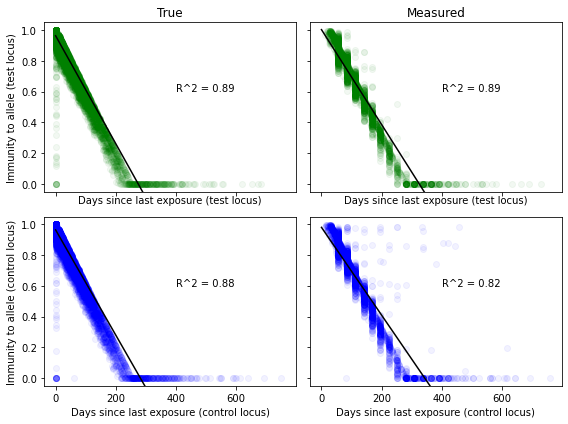

In [301]:
ctrl_immM, ctrl_timesM = getImmExp(a,0,all_parasites,all_immunity,all_malaria=all_malaria)
test_immM, test_timesM = getImmExp(a,5,all_parasites,all_immunity,all_malaria=all_malaria)
ctrl_immT, ctrl_timesT = getImmExp(a,0,all_parasites,all_immunity,all_infections=all_infections)
test_immT, test_timesT = getImmExp(a,5,all_parasites,all_immunity,all_infections=all_infections)

slope_mctrl, intercept_mctrl, r_mctrl, p_mctrl, se_mctrl = st.linregress(ctrl_timesM, ctrl_immM)
slope_tctrl, intercept_tctrl, r_tctrl, p_tctrl, se_tctrl = st.linregress(ctrl_timesT, ctrl_immT)
slope_mtest, intercept_mtest, r_mtest, p_mtest, se_mtest = st.linregress(test_timesM, test_immM)
slope_ttest, intercept_ttest, r_ttest, p_ttest, se_ttest = st.linregress(test_timesT, test_immT)

x = np.arange(700)
y_ttest = (x*slope_ttest) + intercept_ttest
y_mtest = (x*slope_mtest) + intercept_mtest
y_tctrl = (x*slope_tctrl) + intercept_tctrl
y_mctrl = (x*slope_mctrl) + intercept_mctrl

fig,ax = plt.subplots(nrows=2,ncols=2,tight_layout=True,sharey=True,sharex=True,figsize=(8,6))
ax[0,0].plot(test_timesT,test_immT, 'go', alpha=0.05)
ax[0,0].plot(x,y_ttest,color="black")
ax[0,0].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_ttest**2))
ax[0,1].plot(test_timesM,test_immM, 'go', alpha=0.05)
ax[0,1].plot(x,y_mtest,color="black")
ax[0,1].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_mtest**2))
ax[1,0].plot(ctrl_timesT,ctrl_immT, 'bo', alpha=0.05)
ax[1,0].plot(x,y_tctrl,color="black")
ax[1,0].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_tctrl**2))
ax[1,1].plot(ctrl_timesM,ctrl_immM, 'bo', alpha=0.05)
ax[1,1].plot(x,y_mctrl,color="black")
ax[1,1].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_mctrl**2))
ax[0,0].set_title("True")
ax[0,1].set_title("Measured")
ax[0,0].set_ylabel("Immunity to allele (test locus)")
ax[1,0].set_ylabel("Immunity to allele (control locus)")
ax[0,0].set_xlabel("Days since last exposure (test locus)")
ax[1,0].set_xlabel("Days since last exposure (control locus)")
ax[0,1].set_xlabel("Days since last exposure (test locus)")
ax[1,1].set_xlabel("Days since last exposure (control locus)")
ax[0,0].set_ylim(-0.05,1.05)

Unsurprisingly control & test loci have the same plot because weight = 0 at control loci, but you still gain & lose immunity.

When looking at measured values, if you look back to immunity at the visit prior to the one with the new infection, you get a nice correlation.

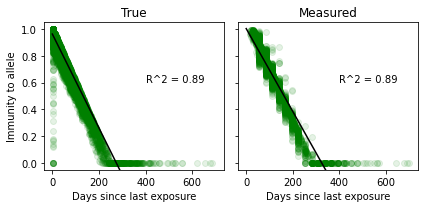

In [303]:
test_immM, test_timesM = getImmExp(a,5,all_parasites,all_immunity,all_malaria=all_malaria)
test_immT, test_timesT = getImmExp(a,5,all_parasites,all_immunity,all_infections=all_infections)
slope_mtest, intercept_mtest, r_mtest, p_mtest, se_mtest = st.linregress(test_timesM, test_immM)
slope_ttest, intercept_ttest, r_ttest, p_ttest, se_ttest = st.linregress(test_timesT, test_immT)

x = np.arange(600)
y_ttest = (x*slope_ttest) + intercept_ttest
y_mtest = (x*slope_mtest) + intercept_mtest

fig,ax = plt.subplots(ncols=2,tight_layout=True,sharey=True,sharex=True,figsize=(6,3))
ax[0].plot(test_timesT,test_immT, 'go', alpha=0.1)
ax[0].plot(x,y_ttest,color="black")
ax[0].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_ttest**2))
ax[1].plot(test_timesM,test_immM, 'go', alpha=0.1)
ax[1].plot(x,y_mtest,color="black")
ax[1].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_mtest**2))
ax[0].set_title("True")
ax[1].set_title("Measured")
ax[0].set_ylabel("Immunity to allele")
ax[0].set_xlabel("Days since last exposure")
ax[1].set_xlabel("Days since last exposure")
ax[0].set_ylim(-0.05,1.05)
fig.savefig("../figs/immunity_timesinceexposure.pdf")

## 2. Parasite density & time since last infection

We have to decide which parasite density to pull, so we'll consider initial, all, max & area.
### Initial
This only works for measured...

In [307]:
def getPdensityExpInitial(a,locus,all_parasites,all_malaria):
    '''
    Returns Pdensity & Time since exposure for a locus from a cohort of simulations.
    '''
    n_people = len(all_malaria)
    print(n_people)
    all_pdens = []
    all_times= []
    for person in range(n_people):
        visits = pc.get_visits(all_malaria[person],28,y)
        for allele in range(a[locus]):
            starts, times = get_times_since(locus,allele,all_parasites[person,...],visits=visits)
            if len(times):
                pdens = np.log10(all_parasites[person,locus,allele,starts])
                all_pdens.extend(pdens)
                all_times.extend(times)
    return all_pdens, all_times

100
100


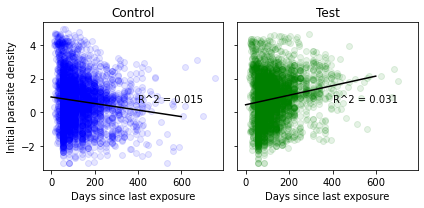

In [313]:
test_pdens, test_times = getPdensityExpInitial(a,5,all_parasites,all_malaria)
ctrl_pdens, ctrl_times = getPdensityExpInitial(a,0,all_parasites,all_malaria)
slope_test, intercept_test, r_test, p_test, se_test = st.linregress(test_times, test_pdens)
slope_ctrl, intercept_ctrl, r_ctrl, p_ctrl, se_ctrl = st.linregress(ctrl_times, ctrl_pdens)

x = np.arange(600)
y_ctrl = (x*slope_ctrl) + intercept_ctrl
y_test = (x*slope_test) + intercept_test

fig,ax = plt.subplots(ncols=2,tight_layout=True,sharey=True,sharex=True,figsize=(6,3))
ax[0].plot(ctrl_times,ctrl_pdens, 'bo', alpha=0.1)
ax[0].plot(x,y_ctrl,color="black")
ax[0].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_ctrl**2))
ax[1].plot(test_times,test_pdens, 'go', alpha=0.1)
ax[1].plot(x,y_test,color="black")
ax[1].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_test**2))
ax[0].set_title("Control")
ax[1].set_title("Test")
ax[0].set_ylabel("Initial parasite density")
ax[0].set_xlabel("Days since last exposure")
ax[1].set_xlabel("Days since last exposure")
fig.savefig("../figs/pdens_timesinceexposure_initial.pdf")

There's no correlation between initial parasite density & time since last exposure. Importantly. There's also no difference between the control & test.

### All
This also only works for measured...

In [314]:
def getPdensExpAll(a,locus, all_parasites,all_malaria):
    '''
    Returns parasite densities and distance since last exposure for all positive visits.
    '''
    n_people = len(all_malaria)
    all_times = []
    all_pdens = []
    
    for person in range(n_people):
        visits = pc.get_visits(all_malaria[person],28,y)
        for allele in range(a[locus]):
            values = all_parasites[person,locus,allele,visits]
            positiveVisits = values.nonzero()[0]
            positiveDays = [visits[loc] for loc in positiveVisits]
            if len(positiveDays):
                shifted = np.roll(positiveDays,1)
                times = positiveDays[1:]-shifted[1:]
                pdens = np.log10(all_parasites[person,locus,allele,positiveDays[1:]])
                all_times.extend(times)
                all_pdens.extend(pdens)
    return all_pdens,all_times

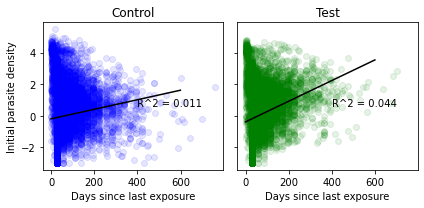

In [320]:
test_pdens, test_times = getPdensExpAll(a,5,all_parasites,all_malaria)
ctrl_pdens, ctrl_times = getPdensExpAll(a,0,all_parasites,all_malaria)

slope_test, intercept_test, r_test, p_test, se_test = st.linregress(test_times, test_pdens)
slope_ctrl, intercept_ctrl, r_ctrl, p_ctrl, se_ctrl = st.linregress(ctrl_times, ctrl_pdens)

x = np.arange(600)
y_ctrl = (x*slope_ctrl) + intercept_ctrl
y_test = (x*slope_test) + intercept_test

fig,ax = plt.subplots(ncols=2,tight_layout=True,sharey=True,sharex=True,figsize=(6,3))
ax[0].plot(ctrl_times,ctrl_pdens, 'bo', alpha=0.1)
ax[0].plot(x,y_ctrl,color="black")
ax[0].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_ctrl**2))
ax[1].plot(test_times,test_pdens, 'go', alpha=0.1)
ax[1].plot(x,y_test,color="black")
ax[1].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_test**2))
ax[0].set_title("Control")
ax[1].set_title("Test")
ax[0].set_ylabel("Initial parasite density")
ax[0].set_xlabel("Days since last exposure")
ax[1].set_xlabel("Days since last exposure")
fig.savefig("../figs/pdens_timesinceexposure_all.pdf")

So there's some slight correlatin with Test, but sligggggght. At least it's greater than control.

What about if I remove all those <= 28 times?

In [321]:
new_testpdens = []
new_testtimes = []
for pdens,time in zip(test_pdens,test_times):
    if time > 28:
        new_testpdens.append(pdens)
        new_testtimes.append(time)
        
new_ctrlpdens = []
new_ctrltimes = []
for pdens,time in zip(ctrl_pdens,ctrl_times):
    if time > 28:
        new_ctrlpdens.append(pdens)
        new_ctrltimes.append(time)

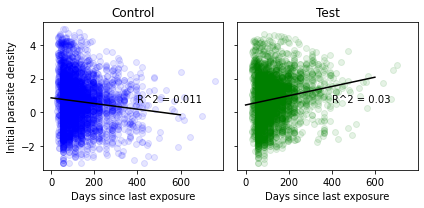

In [323]:
test_pdens = new_testpdens
test_times = new_testtimes
ctrl_pdens = new_ctrlpdens
ctrl_times = new_ctrltimes
slope_test, intercept_test, r_test, p_test, se_test = st.linregress(test_times, test_pdens)
slope_ctrl, intercept_ctrl, r_ctrl, p_ctrl, se_ctrl = st.linregress(ctrl_times, ctrl_pdens)

x = np.arange(600)
y_ctrl = (x*slope_ctrl) + intercept_ctrl
y_test = (x*slope_test) + intercept_test

fig,ax = plt.subplots(ncols=2,tight_layout=True,sharey=True,sharex=True,figsize=(6,3))
ax[0].plot(ctrl_times,ctrl_pdens, 'bo', alpha=0.1)
ax[0].plot(x,y_ctrl,color="black")
ax[0].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_ctrl**2))
ax[1].plot(test_times,test_pdens, 'go', alpha=0.1)
ax[1].plot(x,y_test,color="black")
ax[1].text(400,0.6, "R^2 = " + "{0:.2g}".format(r_test**2))
ax[0].set_title("Control")
ax[1].set_title("Test")
ax[0].set_ylabel("Initial parasite density")
ax[0].set_xlabel("Days since last exposure")
ax[1].set_xlabel("Days since last exposure")
fig.savefig("../figs/pdens_timesinceexposure_all28+.pdf")

There's even less of a correlation if you remove the times < 28.

### Max